In [2]:
# Lets import some libraries we will need later on:
import os                                               # The os library provides some functions for interacting with your operating system (your computer system)
import time                                             # The time library provides some time related functions like the wait() command
import numpy as np                                      # numpy or np is a library for processing numerical data. Its mainly just math stuff. 
import cv2                                              # cv2 is a library for image processing which we need later
from PIL import Image                                   # PIL Image adds some image processing tools too
import matplotlib.pyplot as plt                         # matplotlib.pyplot is a great tool for displaying data on graphs or other media 
%matplotlib inline
from pynq_dpu import DpuOverlay                         


#Now lets define some variables for later and get the DPU ready:
image_folder = 'drunet_img'                                    # Specifies which folder to look in for photos        

In [13]:
overlay = DpuOverlay("dpu.bit")                
overlay.load_model("ofa_rcan_latency_pt.xmodel")

In [14]:
#Here we are creating a list that contains all of the .jpeg photos in the image folder we specified earlier
original_images = [i for i in os.listdir(image_folder) if i.endswith("png")]
total_images = len(original_images)
print("Number of Photos:" + str(total_images))

Number of Photos:5


In [15]:
MEANS = [.485, .456, .406]
STDS = [.229, .224, .225]

def preprocess_fn(image):
    image = image.astype(np.float32)
    image =  image / 255.0
    for j in range(3):
        image[:, :, j] -= MEANS[j]
    for j in range(3):
        image[:, :, j] /= STDS[j]
    return image

In [16]:
dpu = overlay.runner

In [17]:
# Here we assign the input and output tensors to variables we can use later.
inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

shapeIn = tuple(inputTensors[0].dims)    
print(shapeIn)
shapeOut = tuple(outputTensors[0].dims) 
print(shapeOut)
# outputSize = int(outputTensors[0].get_data_size() / shapeIn[0]) # While you dont need this, you can find out the size of your output too!

(1, 360, 640, 3)
(1, 720, 1280, 3)


In [18]:
input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]
output_data = [np.empty(shapeOut, dtype=np.float32, order="C")]
image = input_data[0]

In [41]:
def run(image_index, display=False):
    # Read input image
    input_image = cv2.imread(os.path.join(image_folder, original_images[image_index]))
    # Pre-processing
    resized = cv2.resize(input_image,(360,640))
    preprocessed = preprocess_fn(resized)
    
    # Fetch data to DPU and trigger it
    image[0,...] = preprocessed.reshape(shapeIn[1:])
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)                                       
    print(len(output_data))
    print(len(output_data[0]))
    print(len(output_data[0][0]))
    print(len(output_data[0][0][0]))
    print(len(output_data[0][0][0][0]))
    
    # Retrieve output data
    #classMap_numpy = np.argmax(output_data[0][0], axis=-1).astype(np.uint8)
    np_arr = np.asarray(output_data)
    np_arr = np_arr[0][0]
    np_arr = np_arr/8
    np_arr = np_arr + .5
    if display:
        _, ax = plt.subplots(1) # Display segmented Image
        _ = ax.imshow(np_arr)
        
        
        display_image = cv2.imread(os.path.join(    # Display original image
            image_folder, original_images[image_index]))
        _, ax = plt.subplots(1)
        _ = ax.imshow(cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB))

1
1
720
1280
3


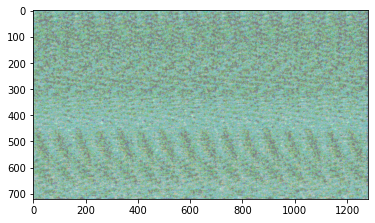

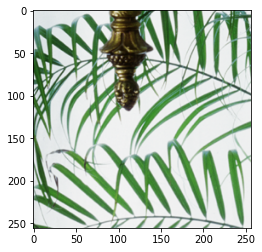

In [42]:
run(0, display=True) # Note the first arguement in the run function takes the 
                     # index of the photo you want, not the photo itself.

In [12]:
del dpu
del overlay